In [104]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784" ,version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
mnist.data.shape # features

(70000, 784)

In [5]:
mnist.target.shape # target

(70000,)

In [6]:
mnist.frame.shape # combined

(70000, 785)

In [7]:
X = mnist["data"]
y = mnist["target"]

### Basis EDA

In [8]:
sample_digit = X.iloc[11]

In [9]:
sample_image = sample_digit.values.reshape(28, 28)

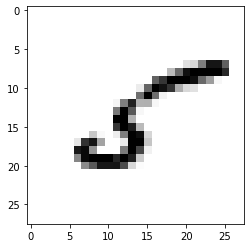

In [10]:
plt.imshow(sample_image, cmap="binary")
# plt.axis("off")
plt.show()

In [11]:
sample_label = y[11]
sample_label

'5'

In [12]:
y = y.astype(np.uint8) # converting string labels to integers

In [135]:
X_train, X_test, y_train, y_test = X.iloc[:60000], X.iloc[60000:], y.iloc[:60000], y.iloc[60000:]

### Implementing binary classifier

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [15]:
from sklearn.linear_model import SGDClassifier 

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

##### Note:
    - SGDclassifier relies on randomness during training. So to get reproducible results set random_state to 42

In [16]:
sgd_clf.predict([sample_digit])

D:\programs\TheCompleteML\env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

#### Performance measures

In [17]:
"""Occasionally you will need more control over the cross-validation 
process than what Scikit-Learn provides off the shelf. 
In these cases, you can implement cross-validation yourself. 
The following code does roughly the same thing as Scikit-Learn’s 
cross_val_score() function, and it prints the same result:"""


from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

sk_fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in sk_fold.split(X_train, y_train_5):
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]
    
    clone_clf = clone(sgd_clf)
    clone_clf.fit(X_train_fold, y_train_fold)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


In [18]:
# replication of above method with the coss-validation score
from sklearn.model_selection import cross_val_score

clone_clf = clone(sgd_clf)
cross_val_score(clone_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

##### Observations 
    - Here accuracy is about 92% and also higher than it. But unfortunately it is due to more skewed datasets. It hase 90% false(not five) and 10% true(five) values.
    - So accuracy is not preferred performance measure for classifiers specially when we have skewed datasets

#### Confusion Matrix

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

##### Observations
    - True Negative: 53892
    - False Positive: 687
    - False Negative: 1891
    - True Positive: 3530
    
    Precision: 
        - measure of accuracy of postive predictions 
        - Equation: TP/TP + FP
    Recall: 
        - measurre of positive instances that are correcly classified
        - Equation: TP/TP + FN

#### Precision and Recall

In [21]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [22]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

##### Observations
    - when it claims an image represents a 5, it is coorect only 83.71% of time and it detects 65.12% of the 5s

#### F1 score

In [23]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

##### Notes
    - The F1 score is hamrmonic mean of precision and recall. Regular mean treats all the values equally, the harmonis mean gives much more weight to low values. As a result, the classifier only get a high F1 score if both recall and precision are high

#### To get classifier score 

In [24]:
y_scores = sgd_clf.decision_function([sample_digit])

D:\programs\TheCompleteML\env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [25]:
y_scores

array([4742.52813158])

In [26]:
threshold =  0
(y_scores>threshold)

array([ True])

In [27]:
threshold =  8000
(y_scores>threshold)

array([False])

##### Observations
    - as we increase the threshold recall score will decrease and precision score increases, and vice versa

#### Deciding the threshold?

In [28]:
clone_clf = clone(sgd_clf)

In [29]:
y_scores = cross_val_predict(clone_clf, X_train, y_train_5, cv=3, method="decision_function")

In [30]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [31]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(("Precision", "Recall"))
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.grid()
    plt.show()

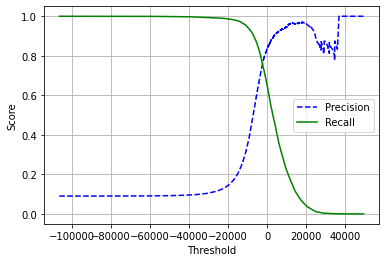

In [32]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [33]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions)
    plt.xlabel("Recalls")
    plt.ylabel("Precisions")
    plt.grid()
    plt.show()

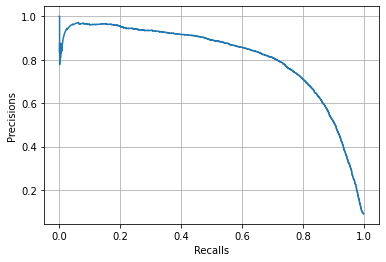

In [34]:
plot_precision_vs_recall(precisions, recalls)

#### To get 90% precision values
    - first we need to get the value of thresholds where precision is just crossing above 90%
    - prediction should be done based on that threshold value rathre then predict method

In [35]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]

In [36]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [37]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [38]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

##### Observations
    - Thus like this we can get whatever precision and recall score.
    - but high precision model with recall is too low can't be used much
    
    Note:
        - If someone says, “Let’s reach 99% precision,” you should ask, “At what recall?”

#### ROC(Receiver operating characteristic) Curve
    - ROC curve the TPR(True positive rate) againts the FPR(False positive rate)
    - FPR is the ratio negative instances that are incorrectly classified
    - Equation: FPR = 1 - TNR
    - TNR is ratio of negative instances that are correctly classsified. Which is also known as specificity
    - Hence ROC curve plots sensitivity vs 1 - specificity 

In [39]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [40]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.title(label)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Negative Rate")
    plt.grid()
    plt.show()

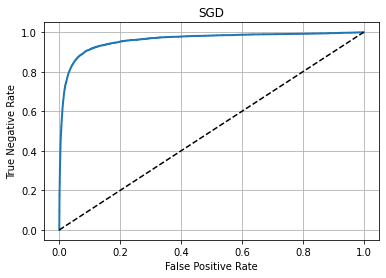

In [41]:
plot_roc_curve(fpr, tpr, label="SGD")

##### Observations
    - Again trade-off here, the higher the TPR lower the FPR
    - The dotted line here represents the ROC curve of purely random cladssifier, a good classifier stays as far away from that line
    
##### Note:
        - One way to compare the classifier is to measure the area under the curve(AUC).
        - Perfect classifier will have a ROC AUC 1, where as random classfier will have ROC AUC value 0.5

In [42]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

##### Note
    - As a rule of thumb, one should prefer the PR curve whenever the positive class is rare or when one care more about the
    false positives then the false negatives. Otherwise use the ROC curve.

### Using RandomForestClassfier
    -RandomForestClassifier do not have decision_function method because the way it works. Instead, it has predict_proba method. Sklearn classifier do have either of one or both methods.
    - The predict_proba() method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class

In [43]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(rf_clf, X_train, y_train_5, method="predict_proba")

In [44]:
y_probas_forest

array([[0.14, 0.86],
       [0.99, 0.01],
       [0.98, 0.02],
       ...,
       [0.01, 0.99],
       [0.96, 0.04],
       [0.96, 0.04]])

In [45]:
y_test_5.iloc[0]

False

##### Note
    - Let's take the positive class's probabalities as a score for ROC curve

#### ROC curve

In [46]:
y_scores_forest = y_probas_forest[:, 1]

In [47]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

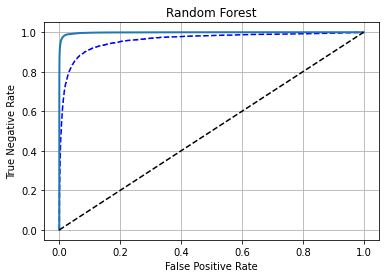

In [48]:
plt.plot(fpr, tpr, "b--", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

In [49]:
roc_auc_score(y_train_5, y_scores_forest)

0.998402186461512

##### Observations
    - ROC is much closer to left corner so subsequently ROC AUC also quite high

#### PR Curve

In [50]:
pr_forest, re_forest, th_forest = precision_recall_curve(y_train_5, y_scores_forest)

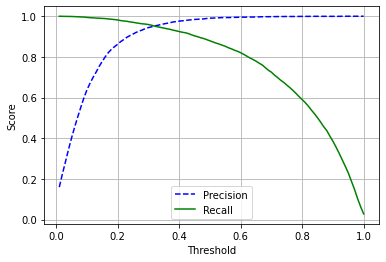

In [51]:
plot_precision_recall_vs_threshold(pr_forest, re_forest, th_forest)

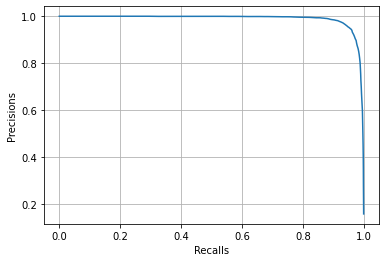

In [52]:
plot_precision_vs_recall(pr_forest, re_forest)

In [53]:
y_train_predi_forest_60 = (y_probas_forest[:, 1]>=0.60)

In [54]:
precision_score(y_train_5, y_train_predi_forest_60)

0.9953020134228188

In [55]:
recall_score(y_train_5, y_train_predi_forest_60)

0.8206972883231876

##### Observations
    - By changing the probabality thresholds we can extend the values for precision and recall score

#### Confusion Matrix

In [56]:
confusion_matrix(y_train_5, y_train_predi_forest_60)

array([[54558,    21],
       [  972,  4449]], dtype=int64)

## Multiclass Classifications
    - Some of the classfiers are capable of handling the multiclass natively such as Logistic Regression, Random Forest, Naive Bayes, where as others such as SGD or SVM are purely binary classifiers.
    - There are two method for multiclass classifications using binary classfiers
        - OneVsRest(OVR)
            - One class is detected against all the other classes.(i.e 0 detector , 1 detector, 2 detector..etc)
        - OneVsOne(OVO)
            - One class is detected against the other one class.(i.e 0 vs 1, 0 vs 2 etc)
    - So in mnist dataset case, first method OVR implements the 10 classifier and, second method OVO implements (N*N-1)/2 means 45 classifiers. OVO can be good method where models scalability decreases with the size of datasets, such as SVM.
    - Scikit-learn automatically detects which of above method to use when we implement the multiclass classifications using binary classifiers

In [60]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([sample_digit])

D:\programs\TheCompleteML\env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

##### Note: 
    - By defaults SVM uses OVO method for classifying the multiclass problem

In [61]:
sample_digit_score = svm_clf.decision_function([sample_digit])

D:\programs\TheCompleteML\env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [62]:
sample_digit_score

array([[ 2.75218106,  7.18427251,  7.26545981,  3.7477651 ,  2.78645349,
         9.3143754 ,  3.77326799,  0.71912451,  7.25839697, -0.3027696 ]])

##### Observations 
    - This gives 10 scores insted of one, each representing the score of each class

In [65]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [66]:
svm_clf.classes_[np.argmax(sample_digit_score)]

5

#### To Explicitly Order the method to be used for multiclass classifications

In [67]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([sample_digit])

D:\programs\TheCompleteML\env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
D:\programs\TheCompleteML\env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
D:\programs\TheCompleteML\env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
D:\programs\TheCompleteML\env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
D:\programs\TheCompleteML\env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
D:\programs\TheCompleteML\env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was

array([5], dtype=uint8)

### SGD Classifier

In [68]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([sample_digit])

D:\programs\TheCompleteML\env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [69]:
sgd_clf.decision_function([sample_digit])

D:\programs\TheCompleteML\env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-30446.28807622, -20771.5971377 ,  -4069.97324426,
         -7297.18084344,  -2335.35560779,   3839.63697115,
        -27845.48223256, -11660.53889926,   -540.54962964,
        -11918.2854924 ]])

In [72]:
clone_clf = clone(sgd_clf)
cross_val_score(clone_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

#### Scaling the features

In [74]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [75]:
cross_val_score(clone_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

##### Observations
    - Scaling the features will significantly improves accuracy from 86% to 89%

### Error Analysis
##### Note:
    Before error analysis we need to implement some of the steps like data preparations options, selecting models by training some of the model and fine tune the best one using the GridSearchCV

In [76]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mat = confusion_matrix(y_train, y_train_pred)

In [77]:
conf_mat

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

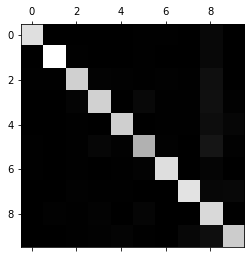

In [79]:
plt.matshow(conf_mat, cmap=plt.cm.gray)
plt.show()

##### Observations
    - Lighter means more accurate, Darker means less accurate
    - Image 5 shows more darker, means it can be two possibilities that there are fewer images of 5 or classfier does not perfoms well on 5 then on others.
    - First, divide each value in the confusion matrix by the number of images in the corresponding class so that you can compare error rates instead of absolute numbers of errors (which would make abundant classes look unfairly bad)

In [86]:
row_sums = conf_mat.sum(axis=1, keepdims=True)

In [91]:
norm_conf_mat = conf_mat/row_sums

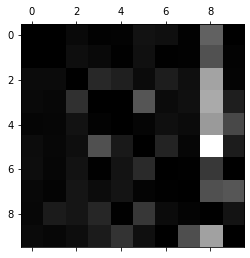

In [98]:
np.fill_diagonal(norm_conf_mat, 0) # this makes opening of errors
plt.matshow(norm_conf_mat, cmap=plt.cm.gray)
plt.show()

##### Observations
    - Here column 8 has so many birght spots, means so many other classes predicted as 8 most is 5, 3 etc and important thing is row 8 has fue bright spot means actual 8s are correctly predicted.
    - Other then 8 column 5 and 3 has bright spot and also symetrical which can't be for all the cases. Means 3 and 5 are misclassified mutually.
    - Analyzing the confusion matrix often gives us insights into ways to improve your classifier. Looking at this plot, it seems that efforts should be spent on reducing the false 8s. For example, you could try to gather more training data for digits that look like 8s (but are not) so that the classifier can learn to distinguish them from real 8s. Or you could engineer new features that would help the classifier — for example, writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none). Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns, such as closed loops, stand out more.

In [99]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train==cl_a) & (y_train_pred==cl_a)]
X_ab = X_train[(y_train==cl_a) & (y_train_pred==cl_b)]
X_ba = X_train[(y_train==cl_b) & (y_train_pred==cl_a)]
X_bb = X_train[(y_train==cl_b) & (y_train_pred==cl_b)]

In [142]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [114]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

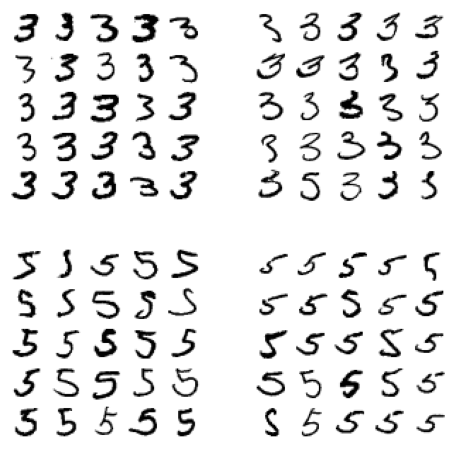

In [115]:
plt.figure(figsize =( 8,8)) 
plt.subplot(221) 
plot_digits(X_aa[: 25], images_per_row = 5) 
plt.subplot(222) 
plot_digits(X_ab[: 25], images_per_row = 5) 
plt.subplot(223) 
plot_digits(X_ba[: 25], images_per_row = 5) 
plt.subplot(224) 
plot_digits(X_bb[: 25], images_per_row = 5) 
plt.show()

 ##### Observations
     - Here see it as confusion matrix. Some of the digits are hard to find with human eyes also.
     - The reason is that we used a simple SGDClassifier, which is a linear model. All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. So since 3s and 5s differ only by a few pixels, this model will easily confuse them. 
     - The main difference between 3s and 5s is the position of the small line that joins the top line to the bottom arc. If you draw a 3 with the junction slightly shifted to the left, the classifier might classify it as a 5, and vice versa. In other words, this classifier is quite sensitive to image shifting and rotation. So one way to reduce the 3/ 5 confusion would be to preprocess the images to ensure that they are well centered and not too rotated. This will probably help reduce other errors as well.

## Multilabel Classifications
    - Multilabel means if you have more then one label to identify.
    - Example: Suppose in the face-recognition system we have to identify each of the faces in the images. i.e to identify the faces Arya, Ananya and Kartavya model should predict like [1, 0, 1], detecting arya and kartavya in image

In [121]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [123]:
knn_clf.predict([sample_digit])

D:\programs\TheCompleteML\env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

##### Observations
    - Correctely identified: five is not large and odd

### Performance Measure of Multilabel
    - There are many ways to do it. One is to measure the F1-score of individual labels, as binary classifier, and count the average of it.

In [125]:
y_multilabel_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [128]:
f1_score(y_multilabel, y_multilabel_pred, average="macro")

0.976410265560605

##### Note:
    - This assumes that all labels are equally important, however, which may not be the case. In particular, if you have many more pictures of Ananya than of Arya or Kartavya, you may want to give more weight to the classifier’s score on pictures of Ananya. One simple option is to give each label a weight equal to its support (i.e., the number of instances with that target label). To do this, simply set average =" weighted" in the preceding code.

## Multioutput Classifications
    - More than one label and each label can have more than one values
    - Example: Removing noise from the images, that takes input as noisy images and predicts the cleanded image data. So here output image data will be of size 784 columns and each columns will be having values from 0 to 255

In [131]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

In [136]:
y_train_mod = X_train
y_test_mod = X_test

In [140]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.iloc[11]])

D:\programs\TheCompleteML\env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


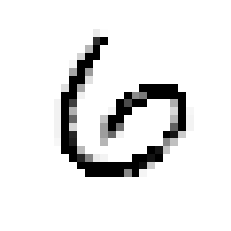

In [143]:
plot_digit(clean_digit)

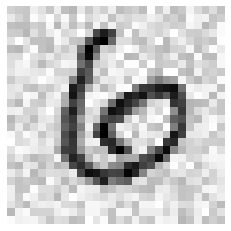

In [148]:
plot_digit(np.array(X_test_mod.iloc[11]))

## Exercises

### MNIST with 90% accuracy

In [149]:
from sklearn.model_selection import GridSearchCV

param_grid = [{ 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance']}]

clone_clf = clone(knn_clf)
grid_search = GridSearchCV(clone_clf, param_grid, cv=3, scoring="accuracy")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [5, 7, 9, 11, 13, 15],
                          'weights': ['uniform', 'distance']}],
             scoring='accuracy')

In [150]:
grid_search.best_params_

{'n_neighbors': 5, 'weights': 'distance'}

In [152]:
grid_search.best_estimator_

KNeighborsClassifier(weights='distance')

In [154]:
final_model = grid_search.best_estimator_
cross_val_score(final_model, X_train, y_train, cv=3, scoring="accuracy")

array([0.9688 , 0.96795, 0.96905])

##### Observations
    - Got 96% accuracy which is quite good.

### MNIST with data augmentation

In [351]:
from scipy.ndimage.interpolation import shift

def add_shifted_images(X, y, shift_=[(0, 1), (0, -1), (-1, 0), (1, 0)]):
    
    """
    Functoin adds the more intances to the training data
    
    Details  One each of the instances it creates the the four copy shifted one pixel towards each of the four directions.
             Also added datas are shuffled before concatenating to the actual data.
    """
    
    if not isinstance(X, np.ndarray): X = np.array(X)
    if not isinstance(y, np.ndarray): y = np.array(y)
    
    dim_ = int(np.sqrt(X.shape[1]))
    X = X.reshape(X.shape[0], dim_, dim_)
    X_shifted = np.empty((X.shape[0]*len(shift_), X.shape[1], X.shape[2]))
    y_ = np.empty(y.shape[0]*len(shift_), dtype="uint8")
    
    for i in range(len(X_shifted)):
        si = i % 4
        xyi = int(i/4)
        X_shifted[i] = shift(X[xyi], shift_[si], cval=0)
        y_[i] = y[xyi]
            
    # reshape
    X_shifted = X_shifted.reshape(X_shifted.shape[0], dim_*dim_)
    X = X.reshape(X.shape[0], dim_*dim_)
    
    # random shuffling of data
    xy = np.c_[X_shifted, y_]
    np.random.seed(42)
    np.random.shuffle(xy)
    X_shifted = xy[:, :-1]
    y_ = xy[:, -1:].ravel()
    del xy
    
    X = np.r_[X, X_shifted]
    y = np.r_[y, y_]
    
    return X, y

In [327]:
X_train_added, y_train_added = add_shifted_images(X_train, y_train)

In [328]:
X_train_added.shape

(300000, 784)

In [329]:
y_train_added.shape

(300000,)

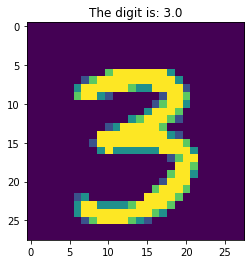

In [350]:
arg = np.random.randint(0, len(X_train_added))
plt.imshow(X_train_added[arg].reshape(28, 28))
plt.title(f"The digit is: {y_train_added[arg]}")
plt.show()

In [352]:
cross_val_score(final_model, X_train_added, y_train_added, cv=3, scoring="accuracy")

array([0.9853 , 0.97996, 0.98032])

##### Observations
    - Data augmentation improves accuracy significantely.